In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import math
# Dataset Class
class SpeedDataset(Dataset):
    def __init__(self, directory, sequence_length=5):
        self.data = []
        self.sequence_length = sequence_length
        self.preprocess_data(directory)

    def preprocess_data(self, directory):
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                speed = float(filename.split('_')[-1].replace('.txt', ''))
                filepath = os.path.join(directory, filename)
                with open(filepath, 'r') as file:
                    track_data = {}
                    for line in file:
                        frame, track_id, x1, y1, x2, y2 = map(float, line.strip().split(',')[:6])
                        if track_id not in track_data:
                            track_data[track_id] = []
                        track_data[track_id].append([x1,y1,x2,y2,(x1+x2)/2, (y1+y2)/2])

                    for track_id, frames in track_data.items():
                        if len(frames) >= self.sequence_length:
                            features = []
                            for i in range(1, len(frames)):
                                current_frame = frames[i]
                                previous_frame = frames[i-1]
                                data_d = []
                                distance = 0
                                for i in range(4):
                                    data_d.append(abs(current_frame[i] - previous_frame[i]))
                                for j in range(4,6):
                                    distance = ((current_frame[j] - previous_frame[j])**2) + distance
                                data_d.append(math.sqrt(distance))
                                features.append(data_d)
                            for i in range(len(features) - self.sequence_length + 1):
                                sequence = features[i:i + self.sequence_length]
                                self.data.append((sequence, speed))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs, output = self.data[idx]
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(output, dtype=torch.float32)




In [18]:
import torch
import torch.nn as nn

class SpeedPredictor(nn.Module):
    def __init__(self, sequence_length, feature_size, embedding_dim, hidden_dim, output_size):
        super(SpeedPredictor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=feature_size, out_channels=embedding_dim, kernel_size=1)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fc2(x)


In [19]:
# Parameters
sequence_length = 5
feature_size = 5
embedding_dim = 128
hidden_dim = 64
output_size = 1

# Initialize model, loss, and optimizer
model = SpeedPredictor(sequence_length, feature_size, embedding_dim, hidden_dim, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        for inputs, speeds in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Squeeze to remove the extra dimension

            # Ensure output and speeds have the same dimensions
            if outputs.shape != speeds.shape:
                outputs = outputs[:speeds.size(0)]  # Adjust output to match speeds size

            loss = criterion(outputs, speeds)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, speeds in val_loader:
                outputs = model(inputs)
                outputs = outputs.squeeze()  # Squeeze to remove the extra dimension

                # Ensure output and speeds have the same dimensions
                if outputs.shape != speeds.shape:
                    outputs = outputs[:speeds.size(0)]  # Adjust output to match speeds size

                loss = torch.sqrt(criterion(outputs, speeds))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        if epoch % 10 ==0:
            print(f'Epoch {epoch+1}/{epochs}, MSE training Loss: {avg_train_loss:.4f}, RMSE validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


Epoch 1/100, MSE training Loss: 2113.7651, RMSE validation Loss: 30.5414
Epoch 11/100, MSE training Loss: 392.4566, RMSE validation Loss: 19.5349
Epoch 21/100, MSE training Loss: 348.1898, RMSE validation Loss: 18.5578
Epoch 31/100, MSE training Loss: 314.9834, RMSE validation Loss: 18.3628
Epoch 41/100, MSE training Loss: 280.1985, RMSE validation Loss: 18.3858
Epoch 51/100, MSE training Loss: 247.6757, RMSE validation Loss: 18.6103
Epoch 61/100, MSE training Loss: 215.4883, RMSE validation Loss: 19.0151
Epoch 71/100, MSE training Loss: 189.4813, RMSE validation Loss: 19.5889
Epoch 81/100, MSE training Loss: 171.9261, RMSE validation Loss: 19.9822
Epoch 91/100, MSE training Loss: 153.3850, RMSE validation Loss: 20.2120


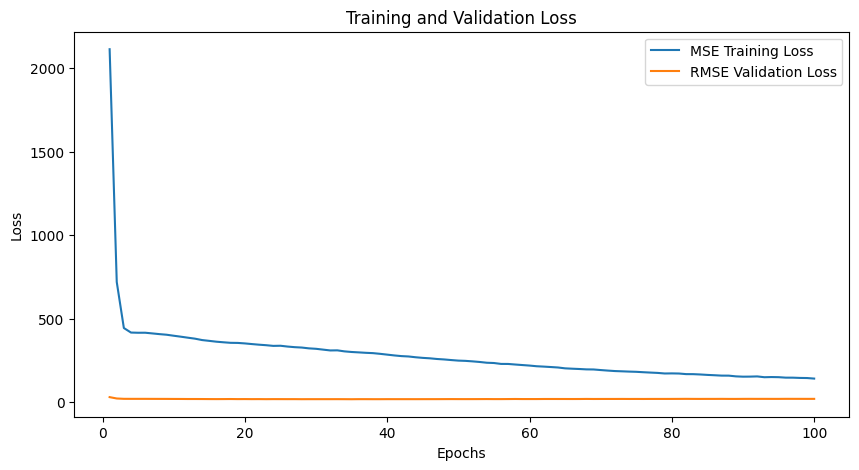

In [21]:
# Loaders
train_dataset = SpeedDataset('outputs', sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = SpeedDataset('test', sequence_length)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)

# Training the model
epochs = 100
train_losses, val_losses = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='MSE Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='RMSE Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [25]:

torch.save(model, 'lstm_Regression_100.pth')


In [26]:
# Load the entire model
model = torch.load('lstm_Regression_100.pth')
model.eval()  # Set the model to evaluation mode


SpeedPredictor(
  (conv1): Conv1d(5, 128, kernel_size=(1,), stride=(1,))
  (lstm): LSTM(128, 64, batch_first=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [27]:
import random
def predict_and_compare(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    predictions = []
    actuals = []
    with torch.no_grad():  # No need to track gradients
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.tolist())  # Collect actual target values
    return predictions, actuals

# Assuming val_loader is properly defined and contains test data
predictions, actuals = predict_and_compare(model, val_loader)

def print_random_predictions(predictions, actuals, num_samples=30):
    if len(predictions) < num_samples:
        num_samples = len(predictions)  # Adjust sample size if predictions are fewer than requested

    # Get random sample indices
    sample_indices = random.sample(range(len(predictions)), num_samples)

    # Print the randomly selected predictions and their actual values
    for idx in sample_indices:
        print(f"Predicted: {predictions[idx]:.4f}, Actual: {actuals[idx]:.4f}")

# Assuming you have already executed the predict_and_compare function
# predictions, actuals = predict_and_compare(model, val_loader)

# Now print randomly selected 30 predictions and their actual values
print_random_predictions(predictions, actuals, 30)



Predicted: 83.0751, Actual: 93.0000
Predicted: 71.1242, Actual: 93.0000
Predicted: 72.5674, Actual: 33.0000
Predicted: 92.4703, Actual: 43.0000
Predicted: 41.6864, Actual: 40.0000
Predicted: 57.3405, Actual: 40.0000
Predicted: 68.7536, Actual: 63.0000
Predicted: 62.6611, Actual: 55.0000
Predicted: 46.7433, Actual: 40.0000
Predicted: 79.8549, Actual: 84.0000
Predicted: 72.8235, Actual: 73.0000
Predicted: 68.8892, Actual: 100.0000
Predicted: 48.4227, Actual: 103.0000
Predicted: 37.8834, Actual: 65.0000
Predicted: 63.6566, Actual: 33.0000
Predicted: 52.9663, Actual: 73.0000
Predicted: 59.0090, Actual: 76.0000
Predicted: 49.8279, Actual: 40.0000
Predicted: 50.7977, Actual: 103.0000
Predicted: 51.9066, Actual: 55.0000
Predicted: 26.7740, Actual: 82.0000
Predicted: 48.7264, Actual: 93.0000
Predicted: 85.9979, Actual: 63.0000
Predicted: 66.2005, Actual: 43.0000
Predicted: 82.6423, Actual: 73.0000
Predicted: 47.2632, Actual: 100.0000
Predicted: 80.4724, Actual: 92.0000
Predicted: 68.6942, Actu